In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

In [2]:
df = pd.read_csv('data/enem_scores.csv')
df.sort_values(by='avg_score', ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


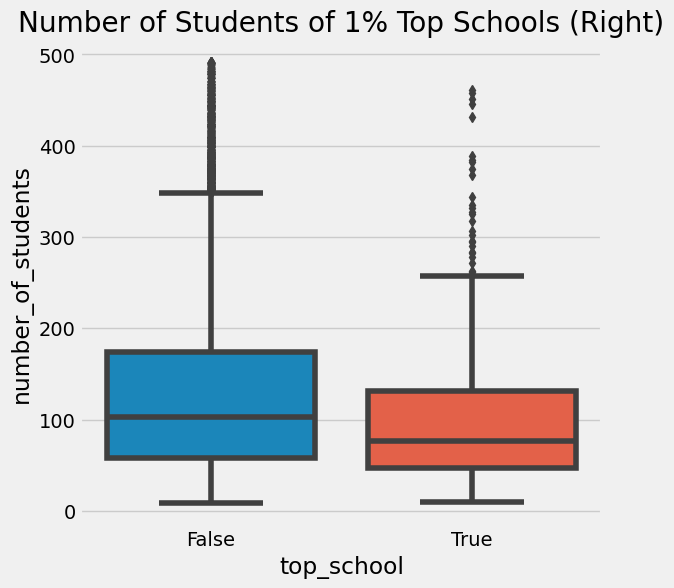

In [3]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

- From the boxplot above, we can tell that at the top 1% of school, they have, on average, fewer students.

## Does smaller school lead to higher academic performance?
- Let's take a look at the bottom 1% of schools

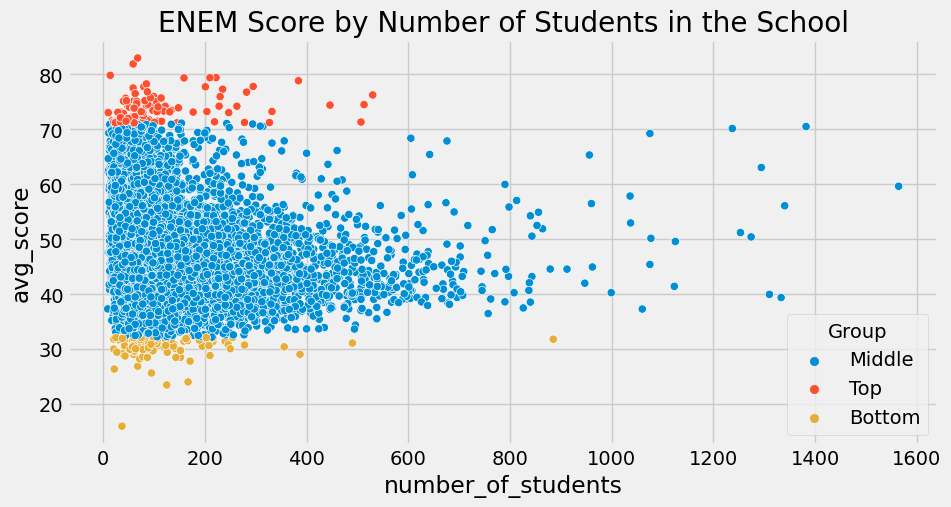

In [4]:
q_99 = np.quantile(df['avg_score'], .99)
q_01 = np.quantile(df['avg_score'], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d : np.select([d['avg_score'] > q_99, d['avg_score'] < q_01],
                                                  ['Top', 'Bottom'], 'Middle')))

plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

- Schools with very few sampels can have very high and low scores simply due to chance
- This graph above shows how the estimates of the school performance have a huge variance when the sample sizes are small.
    - This also indicates that variance shrinks as the sample size increases

# The Standard Error of Our Estimates

In [5]:
data = pd.read_csv('data/online_classroom.csv')
online = data.query('format_ol==1')['falsexam']
face_to_face = data.query('format_ol==0 & format_blended==0')['falsexam']

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print('SE for Online:', se(online))
print('SE for Face to Face', se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face 0.8723511456319106


# Confidence Intervals

- Suppose we have a true abstract distribution of student's test scores with a true mean of 74 and a true standard devaition of 2
- Run 10,000 experiments and on each one, we collect 500 samples

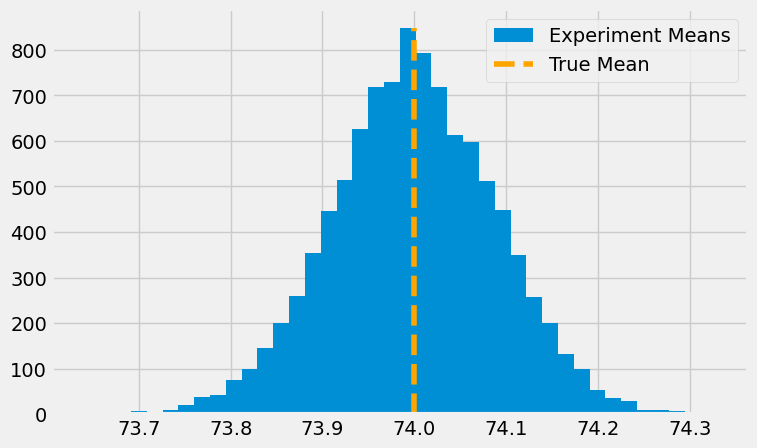

In [6]:
true_std = 2
true_mean = 74

n = 500
def run_experiment():
    return np.random.normal(true_mean, true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();

- With the standard error, we can create an interval that will contain the true mean 95% of the time
- According the Central Limit Theorem, means of experiments are normally distributed
- From statistical theory, we know that 95% of the mass of a normal distribution is between 2 standard deviation above and below the mean

In [7]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.82718114045632, 74.17341543460314)


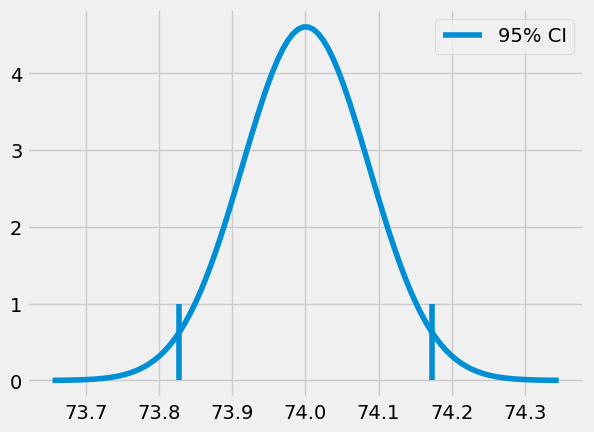

In [8]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

In [9]:
from scipy import stats
z = stats.norm.ppf(.995)  # 0.5% of the mass falls above this value 
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

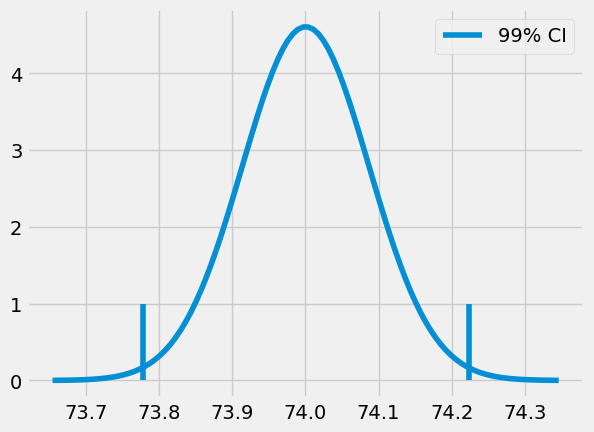

In [10]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99% CI")
plt.legend()
plt.show()

#### Back to classroom experiment, we can construct the confidence interval for the mean exam score for both the online and face to face students' group

In [11]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206951, 80.29218687459715)


- We can see that the 95% CI of the groups doesn't overlap
- This is evidence that our result is not by chance and that the true mean for students in face-to-face classes is higher than the true mean for students in online classes
    - In other words, there is a significant causal decrease in academic performance when switching from face-to-face to online classes

# Hypothesis Testing

- the sum or difference of 2 independent normal distributions is also normal distribution
- the resulting mean will be the sum or difference between the two distributions, while the variance will always be the sum of the variance:

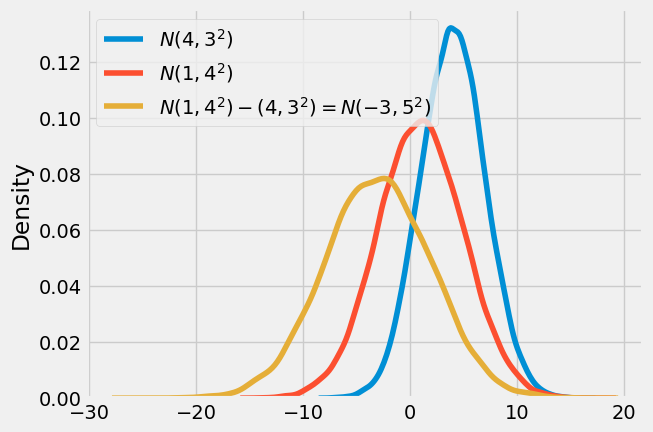

In [12]:
np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(1,4^2) - (4,3^2) = N(-3, 5^2)$")
plt.legend()
plt.show()

#### Construct the distribution of the difference

In [13]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363385, -1.4480327880905248)


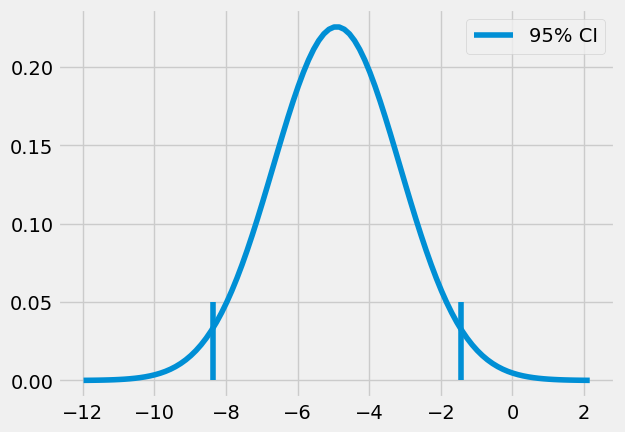

In [14]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

- With this, we can say that we are 95% confident that the true difference between the online and face-to-face groups falls between -8.87 and -1.44
- We can also construct a z-statistic by dividing the difference in mean by the SE of the differences
    - Z statistic is a measure of how extreme the observed difference is
- Null Hypothesis : Assume that the difference is 0
    - If the difference is indeed zero, we would see the z-statistic within 2 standard deviations of the mean 95% of the time

In [15]:
z = diff_mu / diff_se
print(z)

-2.7792810791031224


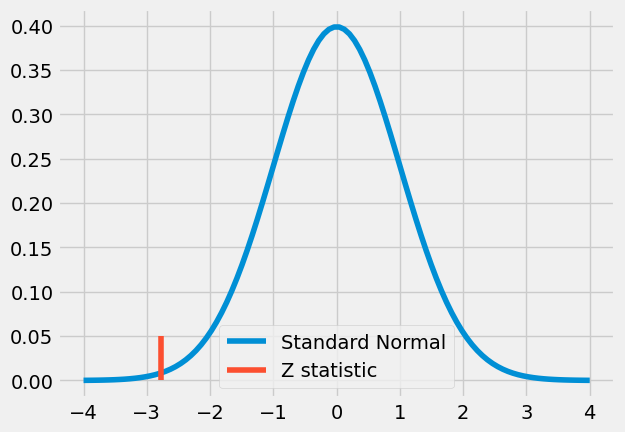

In [16]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color="C1")
plt.legend()
plt.show()

- This looks like a pretty extreme value.
    - It is above 2, which means htere is less than a 5% chance that we would see such an extreme value if there were no difference in the groups
    - This leads us to conclude that switching from face-to-face to online classes causes a statistically significant drop in a academic performance
- Hypothesis test is less conservative than checking if the 95% CI from the treated and untreated group overlaps

- If the confidence intervals in the two groups overlap, it can still be the case that the result is statistically significant

In [17]:
cont_mu, cont_se =  (71, 2)
test_mu, test_se = (80, 4)

diff_mu = test_mu - cont_mu
diff_se = np.sqrt(cont_se**2 + test_se**2)

print("Control 95% CI:", (cont_mu-1.96*cont_se, cont_mu+1.96*cont_se))
print("Test 95% CI:", (test_mu-1.96*test_se, test_mu+1.96*test_se))
print("Diff 95% CI:", (diff_mu-1.96*diff_se, diff_mu+1.96*diff_se))

Control 95% CI: (67.08, 74.92)
Test 95% CI: (72.16, 87.84)
Diff 95% CI: (0.23461352820082482, 17.765386471799175)


- The confidence intervals for Control and Test overlap. However, once we compute the 95% confidence interval for the difference between the groups, we can see that it does not contain zero

# P-Values

- p-value is the probability of seeing such data, given that the null hypothesis is true.
    - It measures how unlikely it is that you are seeing a measurement if the null hypothesis is ture

In [18]:
print('P-value:', stats.norm.cdf(z))

P-value: 0.0027239680835563383


- With a p-value of 0.0027, we see that we have significance up to the 0.2% level. So while the 95% CI and the 99% CI for the difference will neither contain zero, the 99.9%  CI will
- This means that there is only a 0.2% chance of observing this extreme z statistic if the difference was zero

In [19]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% CI:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% CI:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% CI:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.9995)*diff_se))

95% CI: (-8.376346553082909, -1.4480964433710017)
99% CI: (-9.46485353526404, -0.3595894611898709)
99.9% CI: (-10.728040658245558, 0.9035976617916459)


# Key Ideas

In [20]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")
        
AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.7792810791031224
P-Value 0.0027239680835563383


- If we try to reject that the difference between online and face-to-face class performace is -1?

In [21]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.2134920404560883
P-Value 0.013431870694630114


- We can say with 95% confidence that the difference is more signifcant than -1